In [33]:
import jax.numpy as np
from jax import random
from jax.config import config; config.update("jax_enable_x64", True)
from jax_md import space, energy, minimize
from jax import random
from jax import jit
import networkx as nx
import numpy as onp
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

In [34]:
def createDelaunayGraph(NS, rseed, r_c, del_x):

    # This function creates a Delaunay graph of a set of points.

    # Parameters:
    #   NS: The number of points to generate.
    #   rseed: The random seed to use.
    #   r_c: The radius of the circumcircle of each edge in the graph.
    #   del_x: max noise magnitude from square lattice

    # Returns:
    #   N: The number of points in the graph.
    #   G: The graph object.
    #   X: The coordinates of the points.
    #   E: The edges of the graph.

    # Set the random seed.
    onp.random.seed(rseed)

    # Generate the points.
    xm, ym = onp.meshgrid(onp.arange(1, NS + 1), onp.arange(1, NS + 1))
    X = onp.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]

    # Add some noise to the points.
    X = X + del_x * 2 * (0.5 - onp.random.rand(N, 2))

    # Create the Delaunay triangulation.
    DT = Delaunay(X)

    # Get the edges of the triangulation.
    ET = onp.empty((0, 2), dtype=int)
    for T in DT.simplices:
        ET = onp.vstack((ET, [T[0], T[1]], [T[1], T[2]], [T[0], T[2]]))

    # Sort the edges.
    ET = onp.sort(ET)

    # Get the radii of the circumcircles of the edges.
    R = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with radii less than r_c.
    EN = ET[R < r_c, :]

    # Create the adjacency matrix.
    A = onp.zeros((N, N))
    A[EN[:, 0], EN[:, 1]] = 1

    # Create the graph object.
    G = nx.Graph(A)

    # Get the edges of the graph.
    E = onp.array(G.edges)

    return N, G, X, E

In [29]:
N,G,X,E=createDelaunayGraph(20, 25, 2.0, 0.4)

Text(0.5, 1.0, 'Network Topology')

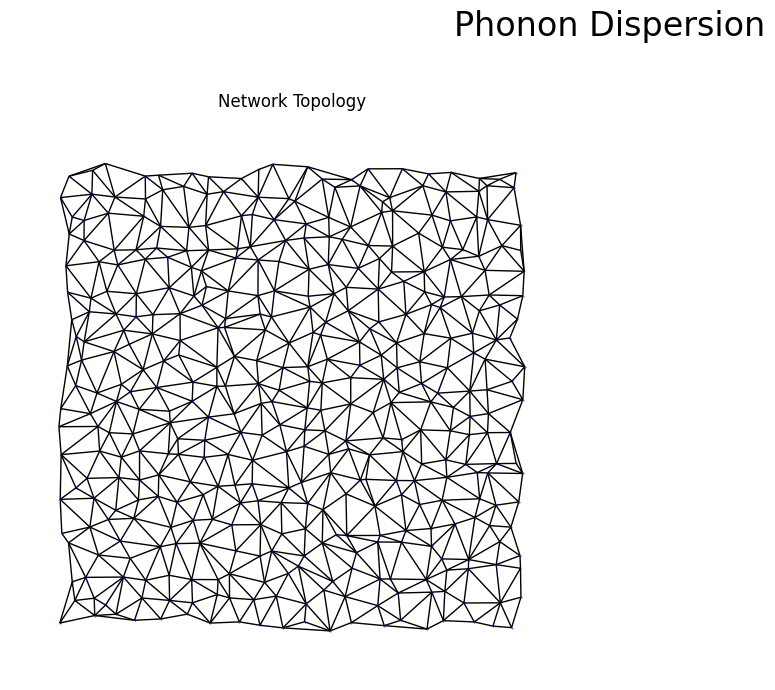

In [35]:
pos = dict(zip(range(N), X))
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Phonon Dispersion", fontsize=24)
ax=plt.subplot(1, 2, 1)
nx.draw(G, pos, node_size=0.1, node_color="blue")
ax.set_aspect('equal')
plt.title("Network Topology")

In [16]:
# Define the system parameters
N = 100  # Number of particles
box_length = 10.0  # Length of the simulation box

# Create the simulation box
displacement, shift = space.periodic(box_length)
R = random.uniform(random.PRNGKey(0), (N, 2)) * box_length

# Define the Lennard-Jones potential and forces
energy_fn = energy.lennard_jones_pair(displacement)

fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

E_init = []
traj_init = []

for i in range(200):
  fire_state = fire_apply(fire_state)
  
  E_init += [energy_fn(fire_state.position)]
  traj_init += [fire_state.position]
  
R = fire_state.position
traj_init = np.stack(traj_init)

# Define the Poisson's ratio calculation function
def poisson_ratio(R):
    # Shift particles along the x-axis
    x_shift = R - np.array([1e-4, 0])

    # Energy minimization
    fire_state = fire_init(x_shift)

    E = []
    traj = []

    for i in range(500):
      fire_state = fire_apply(fire_state)
  
      E += [energy_fn(fire_state.position)]
      traj += [fire_state.position]
  
    R_shifted = fire_state.position
    traj = np.stack(traj)

    # Calculate the strain tensor components
    exx = (R_shifted[:, 0] - R[:, 0]) / box_length
    eyy = (R_shifted[:, 1] - R[:, 1]) / box_length

    # Calculate the average strain
    exx_avg = np.mean(exx)
    eyy_avg = np.mean(eyy)

    # Calculate the Poisson's ratio
    poisson_ratio = -eyy_avg / exx_avg

    return poisson_ratio, E, traj

# Calculate the Poisson's ratio
poisson_ratio_val, E, traj = poisson_ratio(R)
print("Poisson's ratio:", poisson_ratio_val)

Poisson's ratio: -0.7401600525991109


In [12]:
traj_init

Array([[[1.25498265, 6.53293275],
        [8.99868824, 6.13617689],
        [9.54553797, 5.99766808],
        ...,
        [2.04367302, 5.53134571],
        [5.85475679, 5.48997558],
        [8.2072724 , 3.01730537]],

       [[9.8184917 , 2.2095477 ],
        [5.86204178, 9.72562209],
        [6.28284996, 7.59973816],
        ...,
        [4.85275912, 7.24595736],
        [6.34024564, 2.31329746],
        [1.75921645, 4.35360335]],

       [[2.12954236, 7.2356681 ],
        [1.75390625, 5.86914062],
        [8.34082031, 8.47412109],
        ...,
        [8.51856565, 7.71159327],
        [4.95490932, 0.03121758],
        [1.875     , 6.875     ]],

       ...,

       [[8.75578291, 8.04452634],
        [7.69107884, 0.55058975],
        [9.65169771, 6.52841007],
        ...,
        [5.24660955, 7.04662431],
        [2.35880301, 7.85194403],
        [6.20535193, 6.98373286]],

       [[8.75802598, 8.0722504 ],
        [7.67940695, 0.56222761],
        [9.66805078, 6.56709058],
        .

In [17]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Convert the trajectory to a NumPy array
trajectory_array = np.array(traj)

# Create a subplot for the scatter plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]], print_grid=False)

# Create a scatter plot using Plotly
trace = go.Scatter(x=trajectory_array[:, 0], y=trajectory_array[:, 1], mode='markers')
fig.add_trace(trace)

# Create and add slider
steps = []
for i, frame in enumerate(trajectory_array):
    step = dict(
        method="update",
        args=[
            {"x": [frame[:, 0]], "y": [frame[:, 1]]},
            {"xaxis.title": "X", "yaxis.title": "Y", "title": f"Frame: {i}"}
        ],
        label=str(i),
    )
    steps.append(step)

slider = dict(steps=steps, active=0, pad={"t": 50}, currentvalue={"prefix": "Frame: "})

fig.update_layout(sliders=[slider])

# Update the layout
fig.update_layout(
    width=600,
    height=600,
    xaxis=dict(title='X', showgrid=False),
    yaxis=dict(title='Y', showgrid=False),
    plot_bgcolor='rgba(255, 255, 255, 1)', # White background
    margin=dict(l=50, r=50, b=50, t=50) # Adjust margin if needed
)

fig.show()